<a href="https://colab.research.google.com/github/wulanika/klasifikasi-4-jenis-sendok/blob/main/Klasifikasi_4_Jenis_Kelas_Sendok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Install library
!pip install split-folders gdown

In [7]:
# 2. Download dataset dari Google Drive via link (tanpa mount)
import gdown
import zipfile
import os
from pathlib import Path
import random
import shutil

file_id = '14Ne047cR9Rnz7xMGya8ZJzGh9lDvWx1X'  # File ID dari Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", 'dataset.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14Ne047cR9Rnz7xMGya8ZJzGh9lDvWx1X
To: /content/dataset.zip
100%|██████████| 20.8M/20.8M [00:00<00:00, 200MB/s]


'dataset.zip'

In [8]:
# 3. Ekstrak isi ZIP
extract_path = Path("dataset/Dataset (resize)")
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

# 4. Split dataset
original_dataset_dir = extract_path
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder train, val, test
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio
val_split = 0.2
test_split = 0.1

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)

print("✅ Dataset berhasil di-download, diekstrak, dan di-split ke train, val, dan test.")


✅ Dataset berhasil di-download, diekstrak, dan di-split ke train, val, dan test.


In [9]:
# 5. Setup ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

# Path yang benar
train_dir = '/content/dataset/split_dataset/train'
val_dir = '/content/dataset/split_dataset/val'
test_dir = '/content/dataset/split_dataset/test'

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Menampilkan jumlah batch per set
print("Jumlah batch per epoch:")
print(f"Train: {math.ceil(train_generator.n / batch_size)}")
print(f"Validation: {math.ceil(val_generator.n / batch_size)}")
print(f"Test: {math.ceil(test_generator.n / batch_size)}")

Found 840 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Jumlah batch per epoch:
Train: 27
Validation: 8
Test: 4


In [ ]:
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Ukuran gambar dan batch
img_height, img_width = 224, 224
batch_size = 32

# Direktori dataset hasil split
base_dir = "dataset/split_dataset"

# Data Augmentation hanya untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    f"{base_dir}/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    f"{base_dir}/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    f"{base_dir}/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model dengan MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layer dasar
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

# Evaluasi di test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"📊 Akurasi Test: {test_acc:.2f}")

# Menyimpan model setelah pelatihan
model.save('model_trained.h5')

Found 840 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step - accuracy: 0.2459 - loss: 1.8093 - val_accuracy: 0.2375 - val_loss: 1.5039
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 402ms/step - accuracy: 0.3347 - loss: 1.4511 - val_accuracy: 0.3042 - val_loss: 1.3924
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step - accuracy: 0.4062 - loss: 1.3461 - val_accuracy: 0.3792 - val_loss: 1.2836
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.4330 - loss: 1.2680 - val_accuracy: 0.4500 - val_loss: 1.1943
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.4550 - loss: 1.1937 - val_accuracy: 0.4875 - val_loss: 1.1179
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step - accuracy: 0.5368 - loss: 1.1223 - val_accuracy: 0.5542 - val_loss: 1.0561
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - accuracy: 0.5685 - loss: 1.0514 - val_accuracy: 0.5833 - val_loss: 1.0005
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - accuracy: 0.5835 - loss: 0.9877 - val_accu

📊 Akurasi Test: 0.90


In [1]:
import math
num_batches = math.ceil(train_generator.samples / train_generator.batch_size)

NameError: name 'train_generator' is not defined

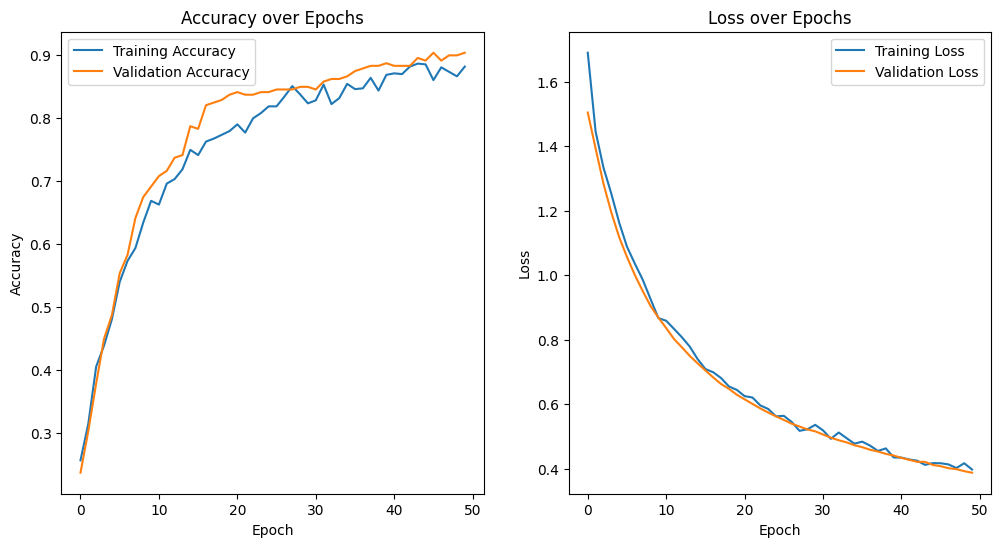

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 971ms/step


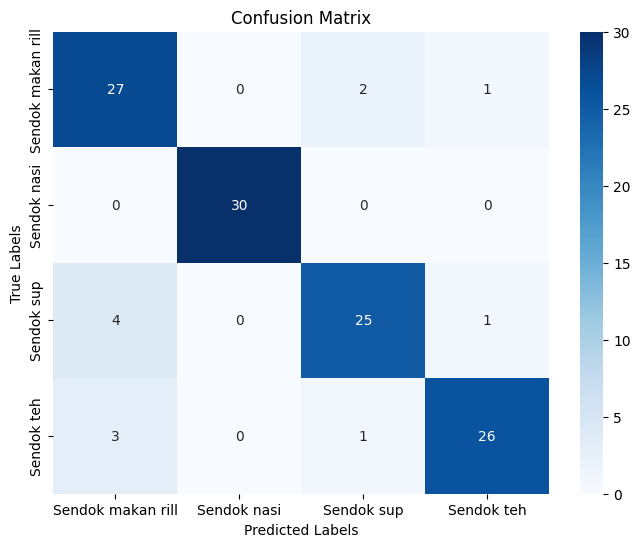

Classification Report:

                   precision    recall  f1-score   support

Sendok makan rill       0.79      0.90      0.84        30
      Sendok nasi       1.00      1.00      1.00        30
       Sendok sup       0.89      0.83      0.86        30
       Sendok teh       0.93      0.87      0.90        30

         accuracy                           0.90       120
        macro avg       0.90      0.90      0.90       120
     weighted avg       0.90      0.90      0.90       120



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Visualisasi grafik akurasi dan loss
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Tampilkan grafik history
plot_history(history)

# Prediksi data test
test_preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


Saving 1744961042597.jpg to 1744961042597.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


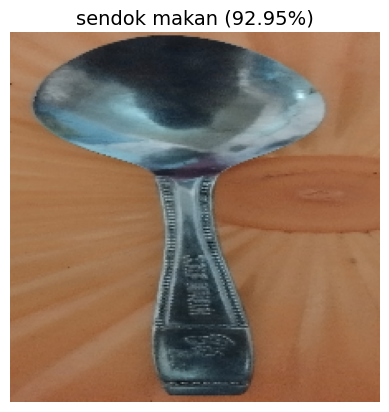

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

# Load model
model = load_model('model_trained.h5')

# Daftar kelas sesuai urutan waktu training
class_labels = ['sendok makan', 'sendok nasi', 'sendok teh', 'sendok sup']

# Fungsi prediksi satu gambar
def predict_uploaded_image(model, uploaded_file):
    img = image.load_img(uploaded_file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_label = class_labels[predicted_index]
    confidence = prediction[0][predicted_index] * 100

    # Tampilkan gambar + label prediksi utama
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label} ({confidence:.2f}%)", fontsize=14)
    plt.show()

# Upload gambar
uploaded = files.upload()

# Prediksi semua gambar yang diupload
for filename in uploaded.keys():
    predict_uploaded_image(model, filename)
